In [1]:
# Import all the goods
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr
plt.style.use('seaborn-whitegrid')

# Import the data files
xl_01 = pd.ExcelFile('20191014_HeartSurvey_edited.xlsx')
survey = xl_01.parse("Sheet1")
xl_02 = pd.ExcelFile('Survey questions key.xlsx')
survey_key = xl_02.parse("Sheet1")

## Extract observer risk scores to its own dataframe
risk = survey.iloc[:, 10:130:2].fillna(50).T ## All the actual questions, risk value
## Rename columns to match observer ID
risk.columns = [i+1 for i in range(18)]
## Rename indices to actual numbers, instead of the crazy codes
risk.index = [i for i in range(60)]

## Extract waitlist decision data to its own dataframe
decision = survey.iloc[:, 11:130:2].T ## All the actual questions, risk value
## Rename waitlist decision columns to match the risk columns
decision.columns = [i+1 for i in range(18)]

## Extract SRTR Risk scores
srtr_risk = pd.DataFrame(survey_key["SRTR Risk"])
## Create a scaled SRTR Risk key
scaler = MinMaxScaler(feature_range=(0,100))
scaled_srtr_risk = scaler.fit_transform(srtr_risk)
scaled_srtr_risk = pd.DataFrame(scaled_srtr_risk, columns=['Scaled SRTR Risk'])

# Create a master dataframe
## Add to the observer risk dataframe SRTR scores and Question IDs as extra columns
risk.insert(0,'Scaled SRTR Risk', scaled_srtr_risk)
risk.insert(0,'SRTR Risk', srtr_risk)
risk.insert(0,'Scenario ID', [i+1 for i in range(60)])

## Unpivot the observer risk dataframe
data_temp = pd.melt(risk, id_vars=['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk'], var_name='Observer ID', value_name='Observer Risk')
## Add to the unpivoted table all the decisions
data_temp.insert(0,'Observer Decision', pd.melt(decision).value)
## Finally, reorganize the columns
master_data = data_temp[['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk', 'Observer ID', 'Observer Risk', 'Observer Decision']]
## Categorize scenarios 1-30 and 31-60 as A and B
scenario_set = np.where(master_data['Scenario ID'] <= 30, 'No SRTR Score', 'With SRTR Score')
master_data.insert(1, 'Scenario Set', scenario_set)

master_data.head()

,Scenario ID,Scenario Set,SRTR Risk,Scaled SRTR Risk,Observer ID,Observer Risk,Observer Decision
0,1,No SRTR Score,15.51,46.304263,1,50.0,Yes
1,2,No SRTR Score,26.40,88.893234,1,92.0,No
2,3,No SRTR Score,7.36,14.430974,1,63.0,Yes
3,4,No SRTR Score,4.01,1.329683,1,0.0,Yes
4,5,No SRTR Score,3.67,0.000000,1,100.0,No


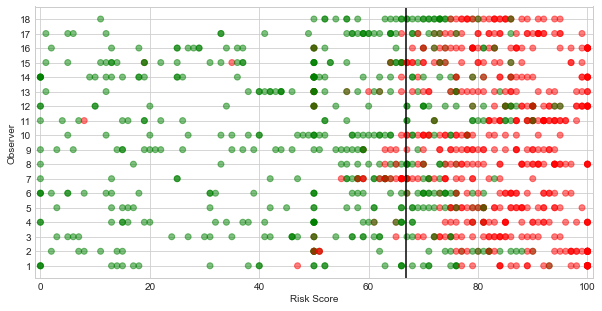

In [2]:
# All scenarios stacked into one chart, with a Mean of Means line thrown in
plt.rcParams['figure.figsize'] = [10, 5]
x = master_data['Observer Risk']
y = master_data['Observer ID']
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.scatter(x, y, marker='o', color=colors, alpha=0.5)
plt.axvline(x=master_data['Observer Risk'].mean(), color='black')
plt.xlim(-1, 101)
plt.ylabel('Observer')
plt.xlabel('Risk Score')
plt.yticks([i+1 for i in range(18)])
;

plt.savefig('AllResults.jpg')

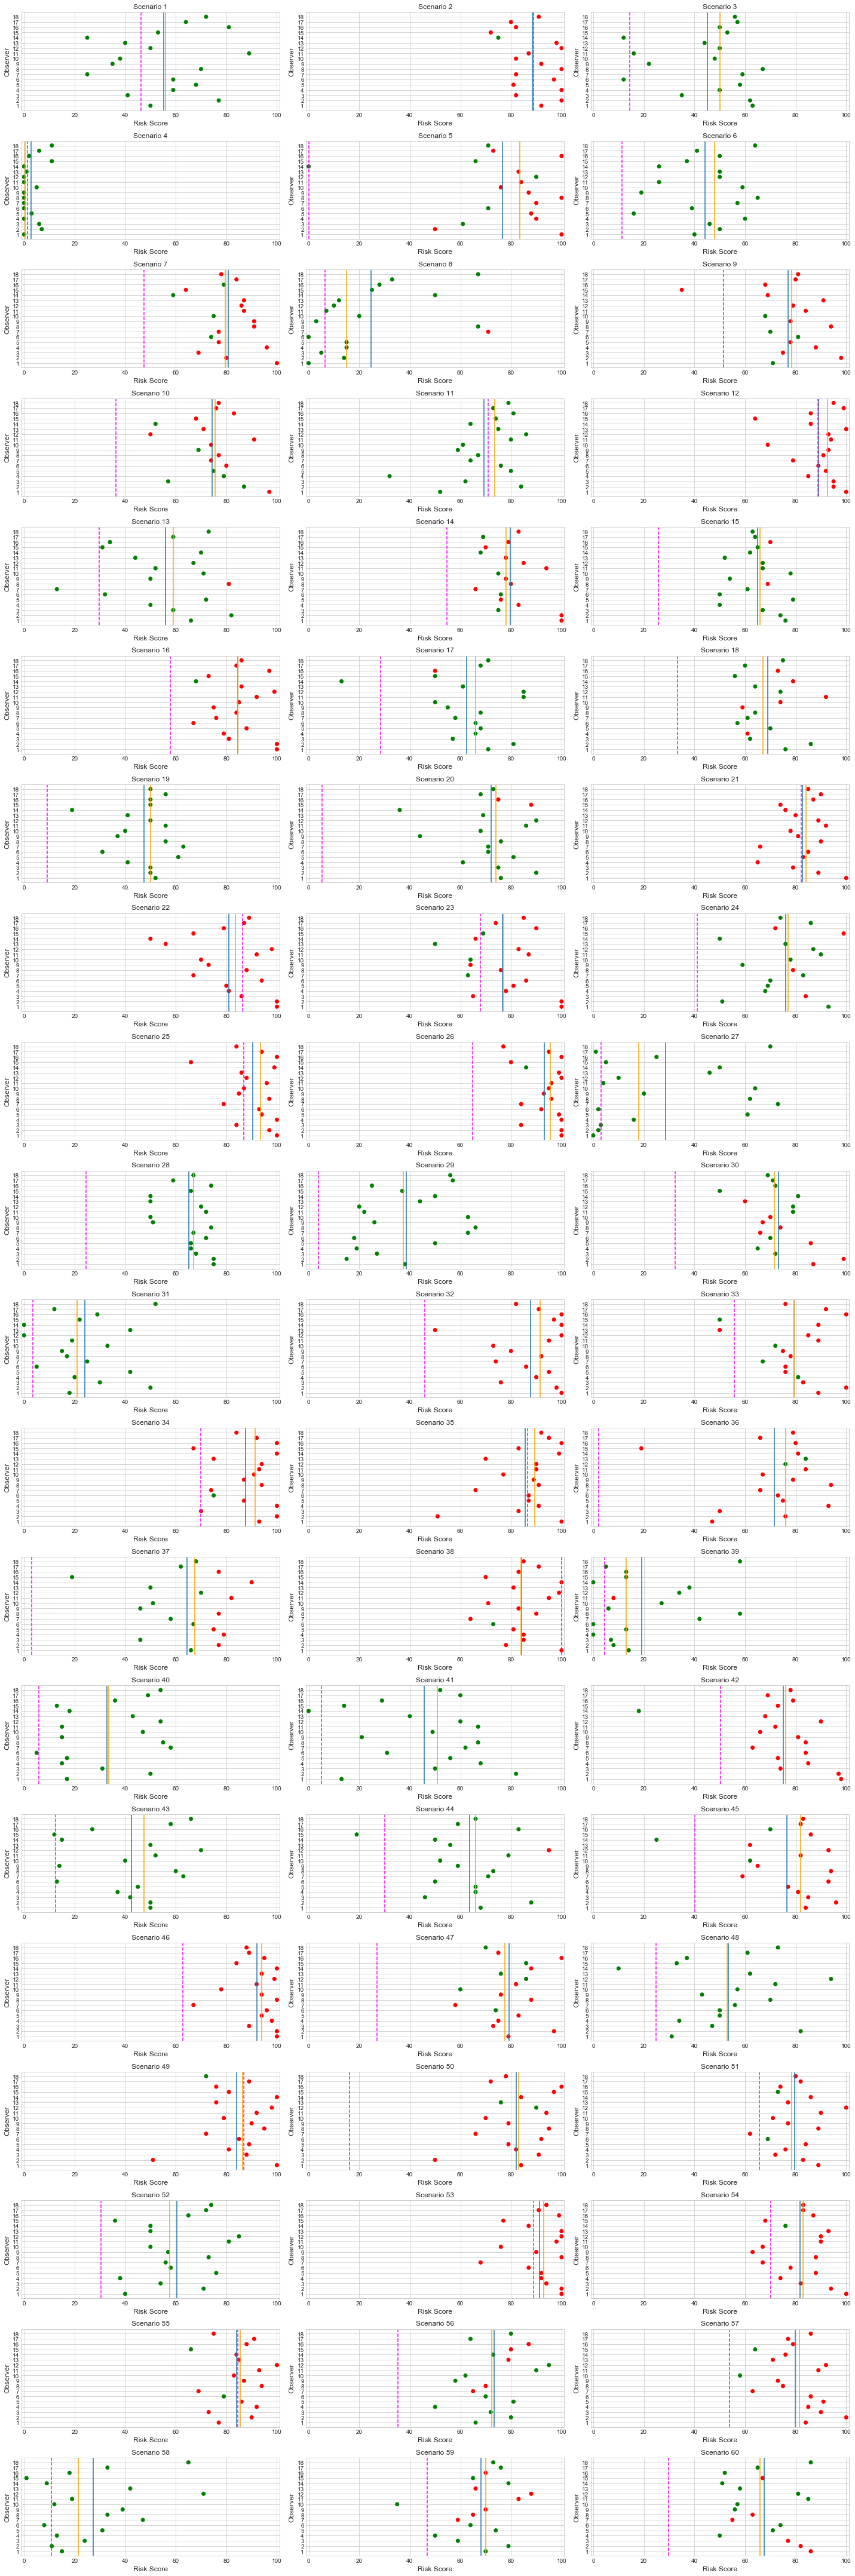

In [3]:
## Plot observer risk/decision for each scenario
#    Mean = blue line
#    Median = orange line
#    Scaled SRTR risk = dotted magenta line

def plotAllScenarios(df):
    plt.rcParams['figure.figsize'] = [20, 60]
    fig, axs = plt.subplots(20, 3)
    scenario = 1
    for i in range(20):
        for j in range(3):
            risk     = df[df['Scenario ID'] == scenario]['Observer Risk']
            observer = df[df['Scenario ID'] == scenario]['Observer ID']
            colors   = df[df['Scenario ID'] == scenario]['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
            srtr     = df[df['Scenario ID'] == scenario]['Scaled SRTR Risk'].max()
            axs[i, j].set_xlim([-1, 101])
            axs[i, j].scatter(risk, observer, color=colors)
            axs[i, j].axvline(x=risk.mean())
            axs[i, j].axvline(x=risk.median(), color='orange')
            axs[i, j].axvline(x=srtr, color='magenta', linestyle='--')
            axs[i, j].set_title(f'Scenario {scenario}', fontsize='large')
            axs[i, j].set_ylabel('Observer', fontsize='large')
            axs[i, j].set_xlabel('Risk Score', fontsize='large')
            axs[i, j].set_yticks([i+1 for i in range(18)])
            scenario += 1
    plt.tight_layout()
    
plotAllScenarios(master_data)

plt.savefig('AllScenarios.jpg')

In [4]:
results_a = master_data.loc[(master_data['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
results_b = master_data.loc[(master_data['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]

results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').index

Int64Index([ 4,  8, 27, 29,  6,  3, 19,  1, 13, 17, 15, 28, 18, 11, 20, 30, 10,
            24,  5, 23,  9, 14,  7, 22, 21, 16,  2, 12, 25, 26],
           dtype='int64', name='Scenario ID')

Text(0.5, 0.98, 'Scenario Risk Scores')

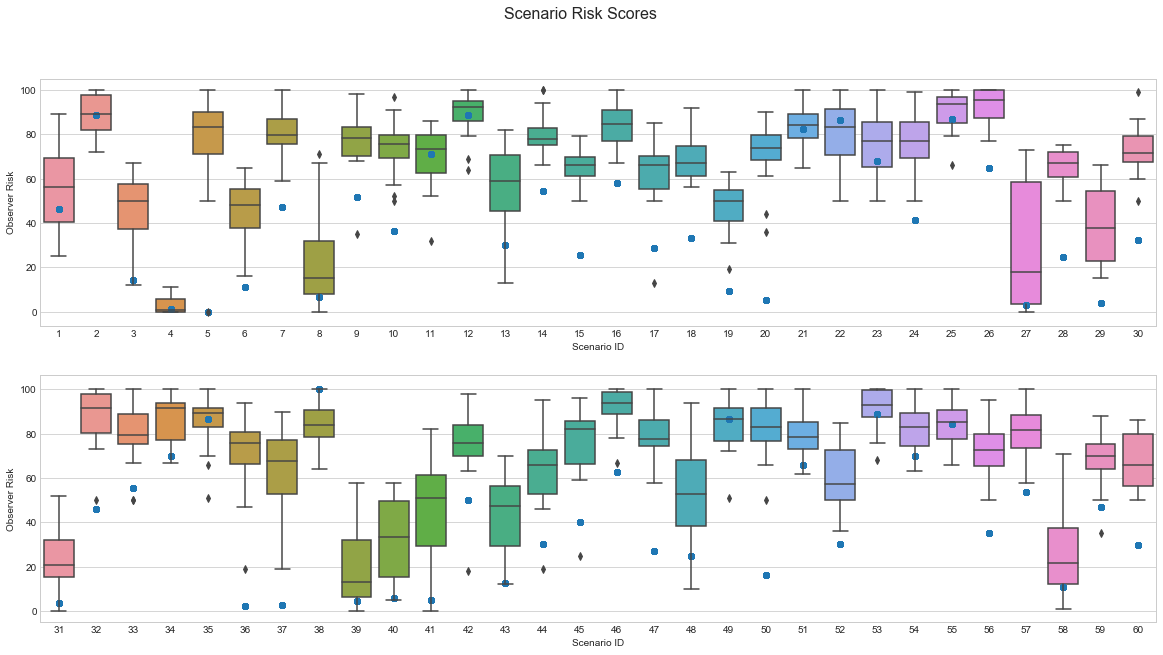

In [5]:
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario
#  Scaled SRTR Score = blue dot

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a)
ax_1 = plt.scatter(results_a['Scenario ID']-1, results_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b)
ax_2 = plt.scatter(results_b['Scenario ID']-31, results_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores', fontsize=16)

#plt.savefig('plot_BoxPerScenario.jpg')

Text(0.5, 0.98, 'Scenario Risk Scores, sorted by SRTR risk')

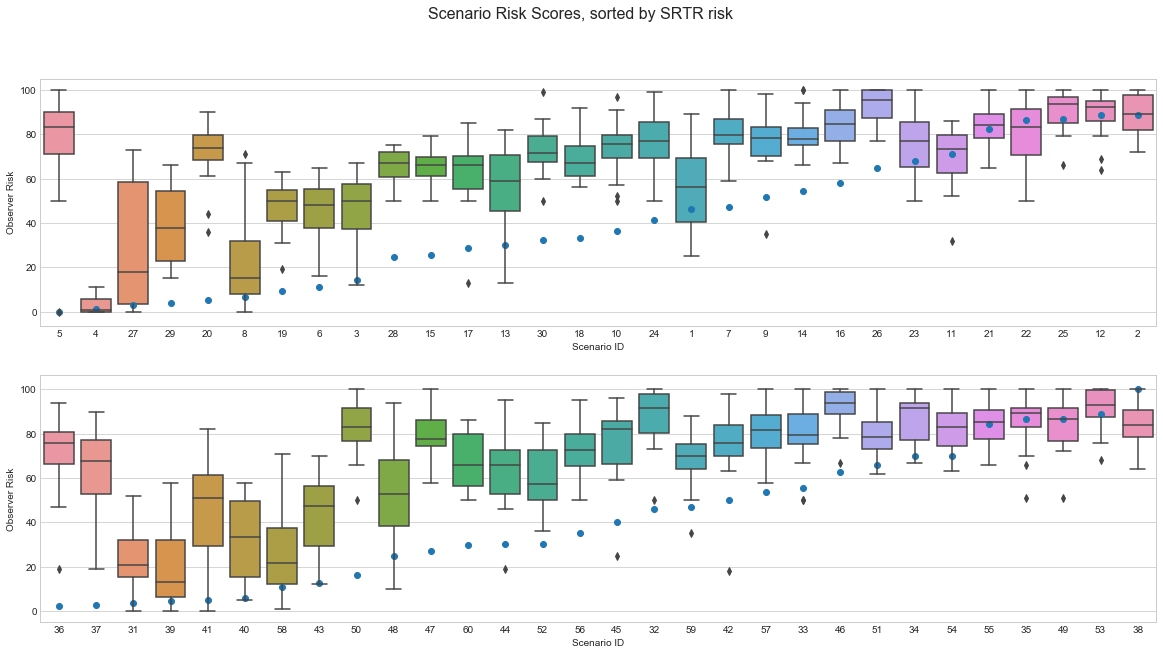

In [6]:
## Same as above, but sorted by increasing SRTR risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_a = results_a[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')
sorted_results_b = results_b.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_b = results_b[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

#plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

Text(0.5, 0.98, 'Scenario Risk Scores, sorted by SRTR risk')

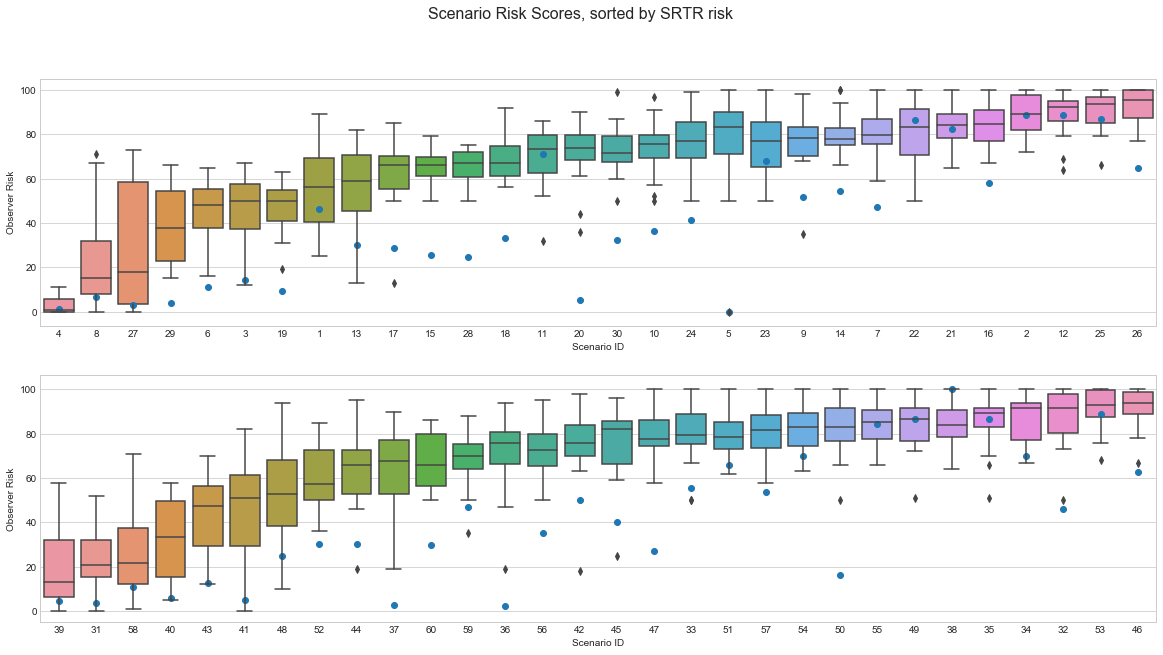

In [7]:
## Same as above, but sorted by increasing observer mean risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').index
sorted_srtr_a = results_a.groupby('Scenario ID').mean().sort_values('Observer Risk')
sorted_results_b = results_b.groupby('Scenario ID').mean().sort_values('Observer Risk').index
sorted_srtr_b = results_b.groupby('Scenario ID').mean().sort_values('Observer Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

#plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

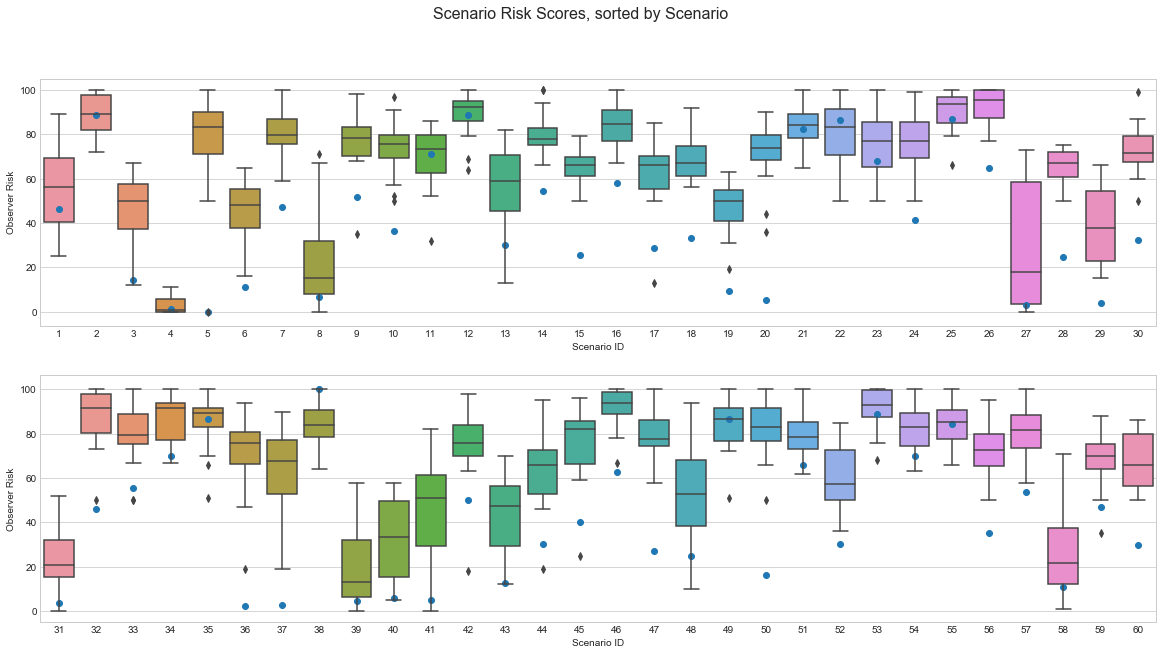

In [8]:
## Same as above, but sorted by increasing observer mean risk score

def results_sorted_by_srtr(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.sort_values('Scaled SRTR Risk')
    results_b_sorted =     results_b.sort_values('Scaled SRTR Risk')
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scaled SRTR Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_mean(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Mean Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_median(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Median Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }


def results_sorted_by_scenario(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted = results_a
    results_b_sorted = results_b
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scenario',
        'first_results': results_a,
        'first_results_sorted': results_a_sorted,
        'first_results_sort_order': results_a_sort_order,
        'first_srtr_sorted': srtr_a_sorted,
        'second_results': results_b,
        'second_results_sorted': results_b_sorted,
        'second_results_sort_order': results_b_sort_order,
        'second_srtr_sorted': srtr_b_sorted
    }

def results_sorted_by_interquartitle_range(df):
    from scipy.stats import iqr
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    # Make two lists of interquartile ranges
    iqr_list = []
    for scenario in df['Scenario ID']:
        iqr_list.append(iqr(df[df['Scenario ID'] == scenario]['Observer Risk']))
    iqr_df = pd.DataFrame(iqr_list, columns=['IQR'])
    iqr_df = iqr_df[:60]
    iqr_df.insert(0, 'Scenario ID', [i+1 for i in range(60)])
    iqr_df.insert(2, 'Scaled SRTR Risk', df[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scaled SRTR Risk'])
    iqr_a = iqr_df[:30]
    iqr_b = iqr_df[30:]
    results_a_sorted = iqr_a.sort_values('IQR')
    results_a_sort_order = results_a_sorted['Scenario ID']
    srtr_a_sorted = results_a_sorted
    srtr_a_sorted.index = [i for i in range(30)]
    results_b_sorted = iqr_b.sort_values('IQR')
    results_b_sort_order = results_b_sorted['Scenario ID']
    srtr_b_sorted = results_b_sorted
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Interquartile Range',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

    
def boxplot_survey(df, sort_by='scenario'):
    plt.figure(figsize=(20, 10))
    if (sort_by == 'mean'):
        results = results_sorted_by_mean(df)
    if (sort_by == 'scenario'):
        results = results_sorted_by_scenario(df)
    if (sort_by == 'srtr'):
        results = results_sorted_by_srtr(df)
    if (sort_by == 'median'):
        results = results_sorted_by_median(df)
    if (sort_by == 'iqr'):
        results = results_sorted_by_interquartitle_range(df)
    first_results = results['first_results']
    first_results_sorted = results['first_results_sorted']
    first_results_sort_order = results['first_results_sort_order']
    first_srtr_sorted = results['first_srtr_sorted']
    second_results = results['second_results']
    second_results_sorted = results['second_results_sorted']
    second_results_sort_order = results['second_results_sort_order']
    second_srtr_sorted = results['second_srtr_sorted']

    plt.subplot(2, 1, 1)
    ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=first_results, order=first_results_sort_order)
    ax_1 = plt.scatter(first_srtr_sorted.index.values, first_srtr_sorted['Scaled SRTR Risk'])
    
    plt.subplot(2, 1, 2)
    ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=second_results, order=second_results_sort_order)
    ax_2 = plt.scatter(second_srtr_sorted.index.values, second_srtr_sorted['Scaled SRTR Risk'])
    
    plt.suptitle(f'Scenario Risk Scores, sorted by {results["title"]}', fontsize=16)



boxplot_survey(master_data)

plt.savefig('plot_BoxPerScenario.jpg')



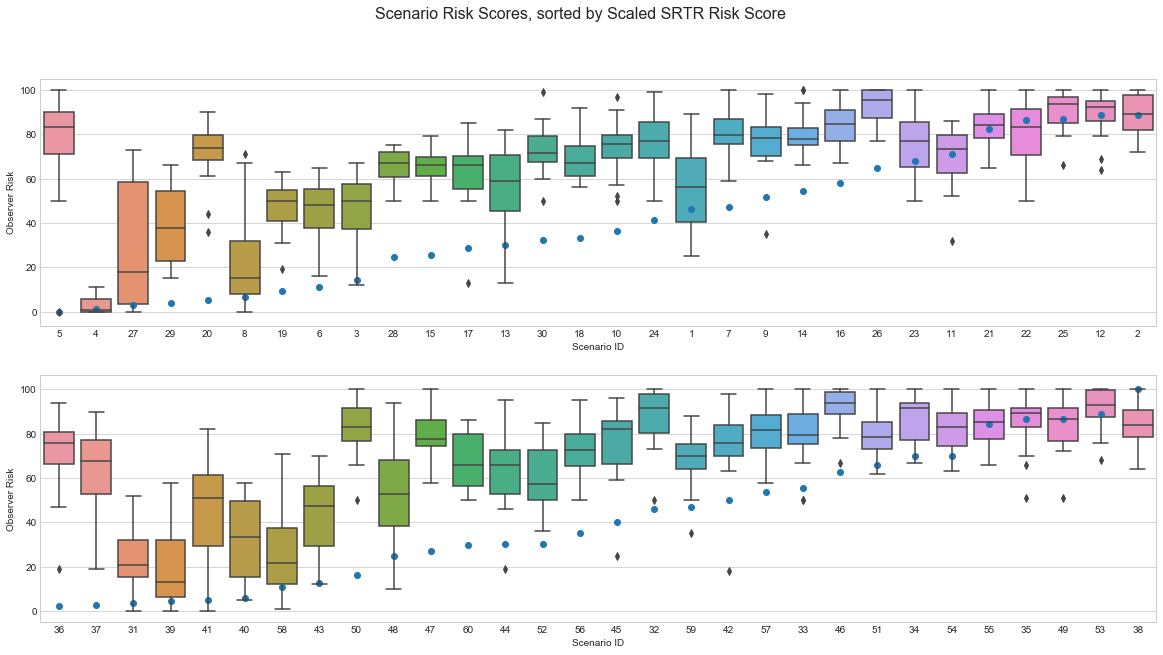

In [9]:
boxplot_survey(master_data, 'srtr')
plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

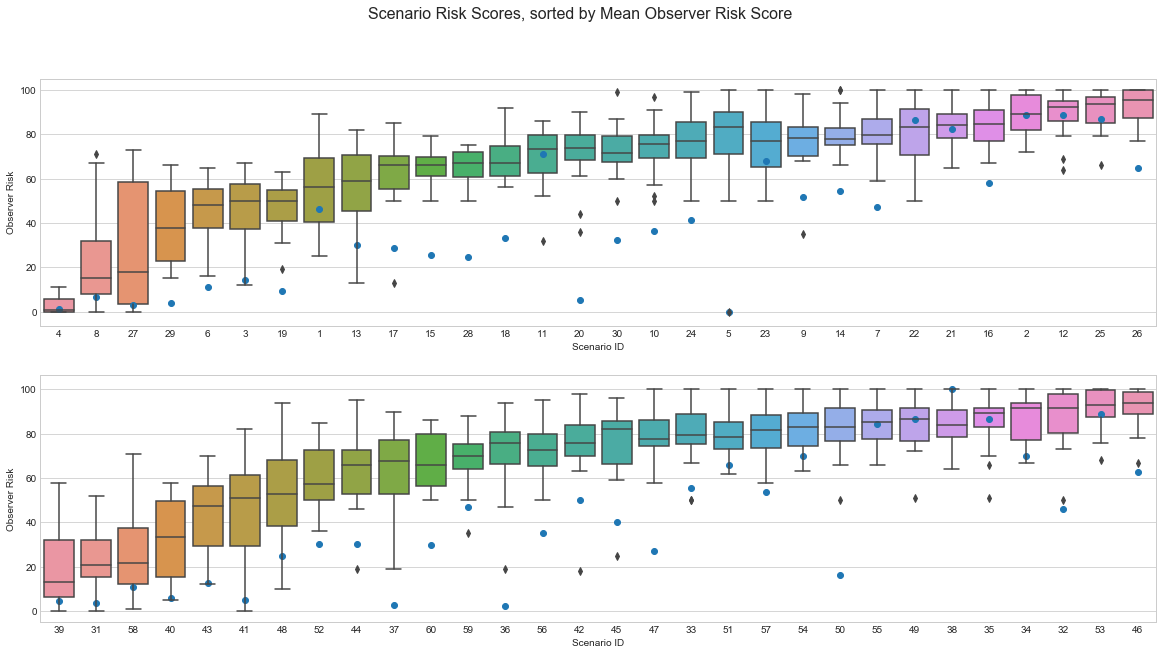

In [10]:
boxplot_survey(master_data, 'mean')
plt.savefig('plot_BoxPerScenario_sortMean.jpg')

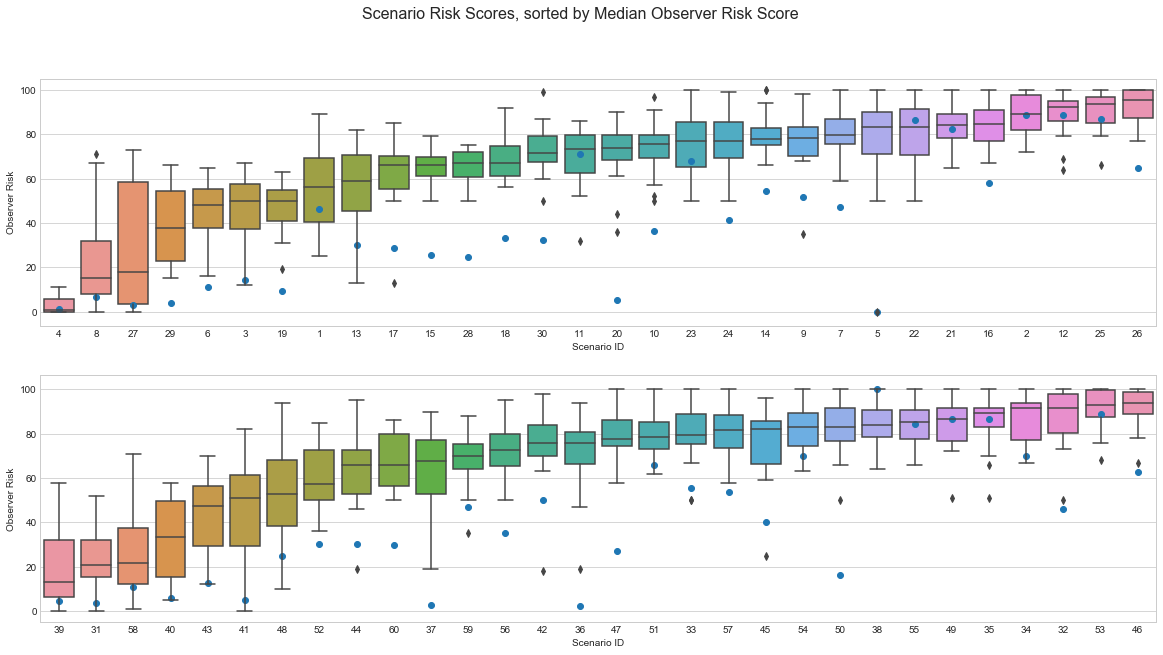

In [11]:
boxplot_survey(master_data, 'median')
plt.savefig('plot_BoxPerScenario_sortMedian.jpg')

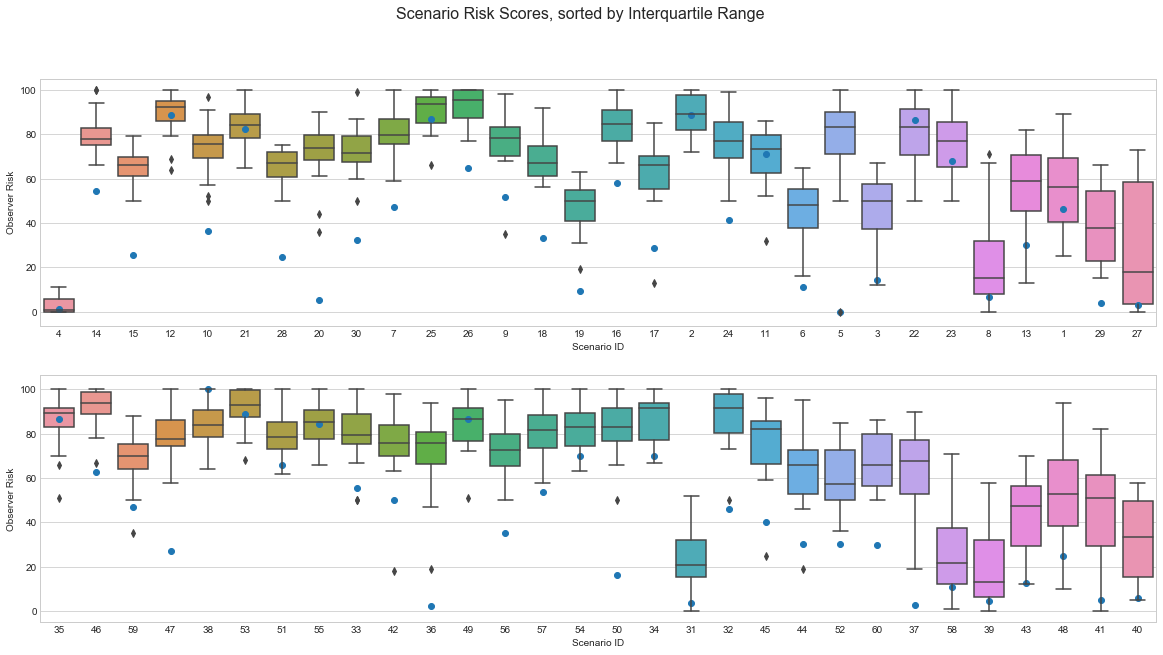

In [12]:
boxplot_survey(master_data, 'iqr')
plt.savefig('plot_BoxPerScenario_sortIQR.jpg')

In [42]:
def calculateDeviationFromMeanByObserver(df, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against the overall mean for that observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        scores_mean = scores.mean()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - scores_mean)**2))
    return np.round(np.array(mse), 2)
    
mse_noscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 1, 30)
mse_withscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]},\t With score {mse_withscore[i]}')

Observer 1:  Without score 789.4,	 With score 520.67
Observer 2:  Without score 885.35,	 With score 730.15
Observer 3:  Without score 522.66,	 With score 272.22
Observer 4:  Without score 487.4,	 With score 526.44
Observer 5:  Without score 540.35,	 With score 484.47
Observer 6:  Without score 761.61,	 With score 801.83
Observer 7:  Without score 457.7,	 With score 151.45
Observer 8:  Without score 340.21,	 With score 329.51
Observer 9:  Without score 406.21,	 With score 375.19
Observer 10:  Without score 369.51,	 With score 211.54
Observer 11:  Without score 1069.81,	 With score 792.69
Observer 12:  Without score 837.36,	 With score 627.0
Observer 13:  Without score 357.44,	 With score 203.74
Observer 14:  Without score 618.23,	 With score 776.51
Observer 15:  Without score 378.76,	 With score 669.36
Observer 16:  Without score 624.38,	 With score 466.74
Observer 17:  Without score 461.1,	 With score 446.0
Observer 18:  Without score 221.03,	 With score 92.73


In [43]:
def calculateDeviationFromSRTRByObserver(df, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against each SRTR score for the observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        scores.index = [i for i in range(start_scenario-1, stop_scenario)]
        srtr_scores = df[scenarios]['Scaled SRTR Risk'].drop_duplicates()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - srtr_scores)**2))
        # print(f'MSE, Observer {observer + 1}:\t{mse[observer]}  (numerator: {np.sum((x-x_mean)**2)}, denominator: {len(x)})')
    return np.round(np.array(mse))
    
mse_noscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 1, 30)
mse_withscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 31, 60)

for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]}, With score {mse_withscore[i]}')

ValueError: Length mismatch: Expected axis has 17 elements, new values have 30 elements

In [41]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score

mse_mean_blind = calculateDeviationFromMeanByObserver(master_data, 1, 30)
mse_mean =       calculateDeviationFromMeanByObserver(master_data, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(master_data, 1, 30)
mse_srtr =       calculateDeviationFromSRTRByObserver(master_data, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR', 'Deviation from Mean, with SRTR'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind, mse_srtr - mse_srtr_blind]),
               index=['Change in Deviation from Mean, without > with', 'Change in Deviation from SRTR, without > with'])

master_data[master_data['Observer Decision'] == 'Yes']

,Scenario ID,Scenario Set,SRTR Risk,Scaled SRTR Risk,Observer ID,Observer Risk,Observer Decision
0,1,No SRTR Score,15.51,46.304263,1,50.0,Yes
2,3,No SRTR Score,7.36,14.430974,1,63.0,Yes
3,4,No SRTR Score,4.01,1.329683,1,0.0,Yes
5,6,No SRTR Score,6.56,11.302307,1,40.0,Yes
7,8,No SRTR Score,5.31,6.413766,1,0.0,Yes
8,9,No SRTR Score,16.87,51.622996,1,71.0,Yes
10,11,No SRTR Score,21.83,71.020727,1,52.0,Yes
12,13,No SRTR Score,11.30,29.839656,1,66.0,Yes
14,15,No SRTR Score,10.25,25.733281,1,76.0,Yes
16,17,No SRTR Score,10.95,28.470864,1,71.0,Yes


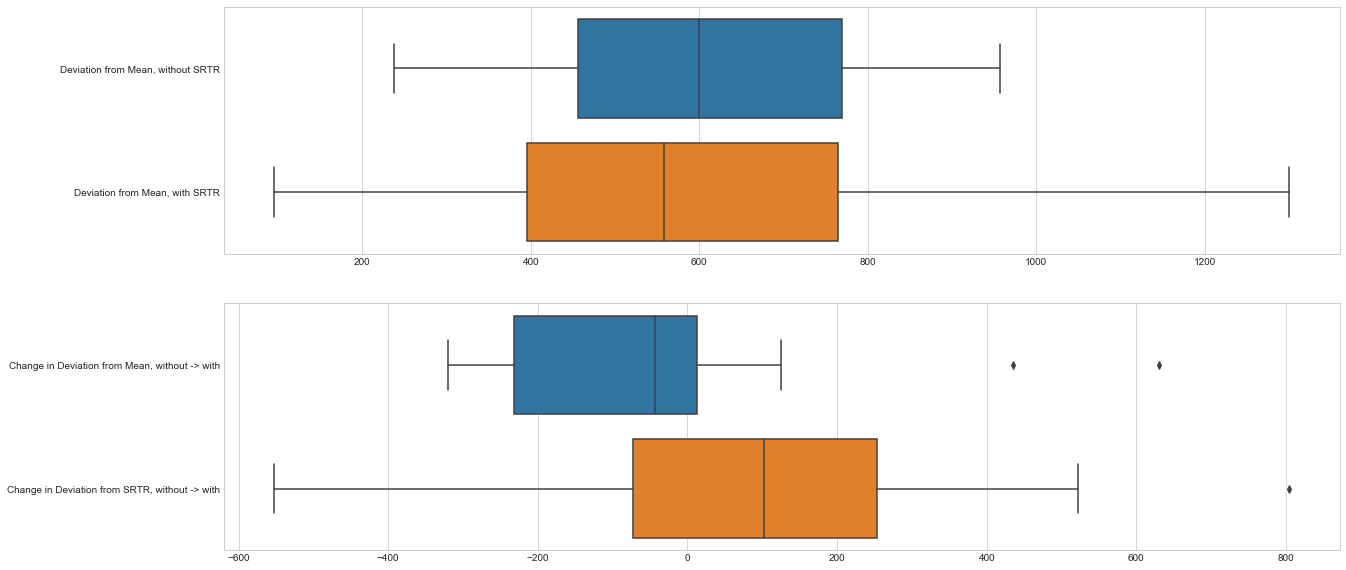

In [20]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score

mse_mean_blind = calculateDeviationFromMeanByObserver(master_data, 1, 30)
mse_mean =       calculateDeviationFromMeanByObserver(master_data, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(master_data, 1, 30)
mse_srtr =       calculateDeviationFromSRTRByObserver(master_data, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR', 'Deviation from Mean, with SRTR'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind, mse_srtr - mse_srtr_blind]),
               index=['Change in Deviation from Mean, without -> with', 'Change in Deviation from SRTR, without -> with'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')


#plt.savefig('plot_BoxDeviations.jpg')


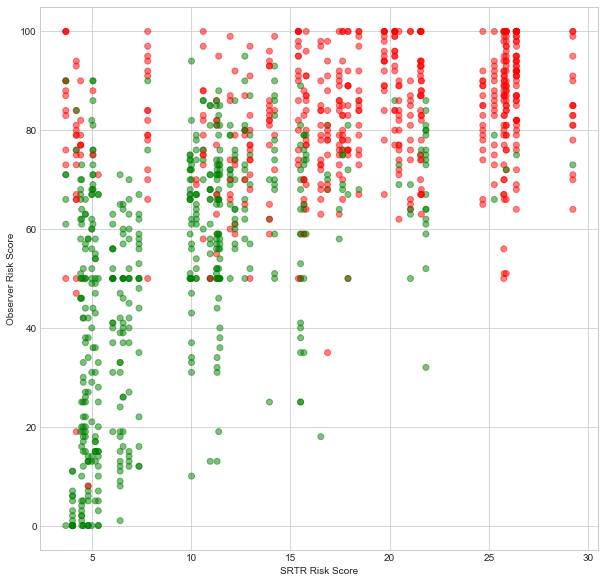

In [21]:
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(master_data['SRTR Risk'], master_data['Observer Risk'], color=colors, alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_all.jpg')

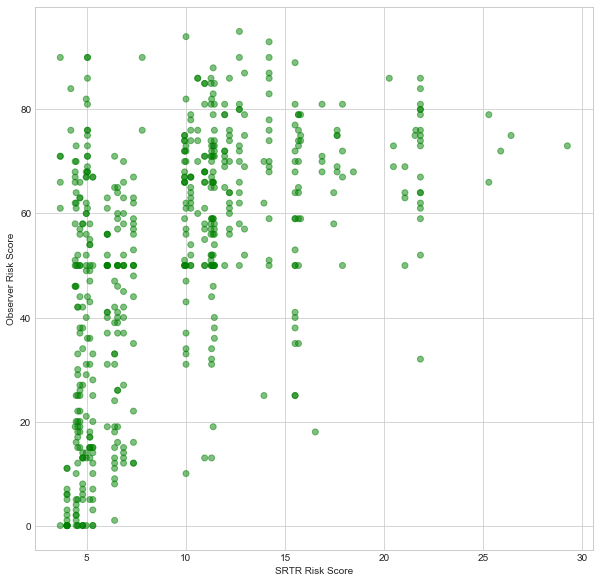

In [24]:
decision_yes = master_data['Observer Decision'] == 'Yes'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_yes]['SRTR Risk'], master_data[decision_yes]['Observer Risk'], color=colors[decision_yes], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_yes.jpg')

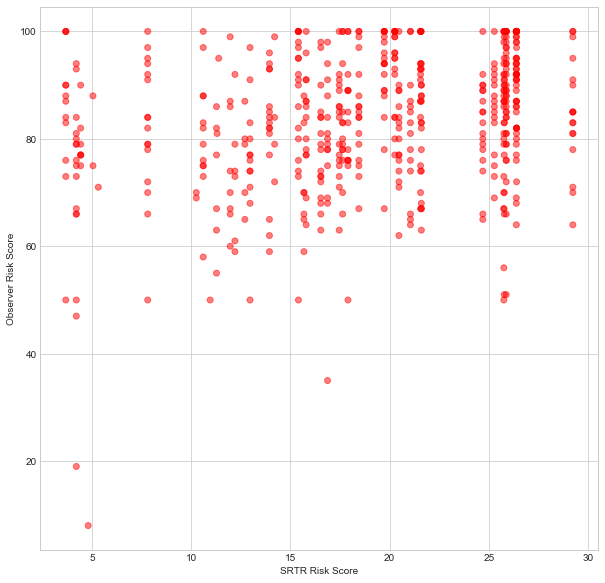

In [25]:
decision_no = master_data['Observer Decision'] == 'No'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_no]['SRTR Risk'], master_data[decision_no]['Observer Risk'], color=colors[decision_no], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_no.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


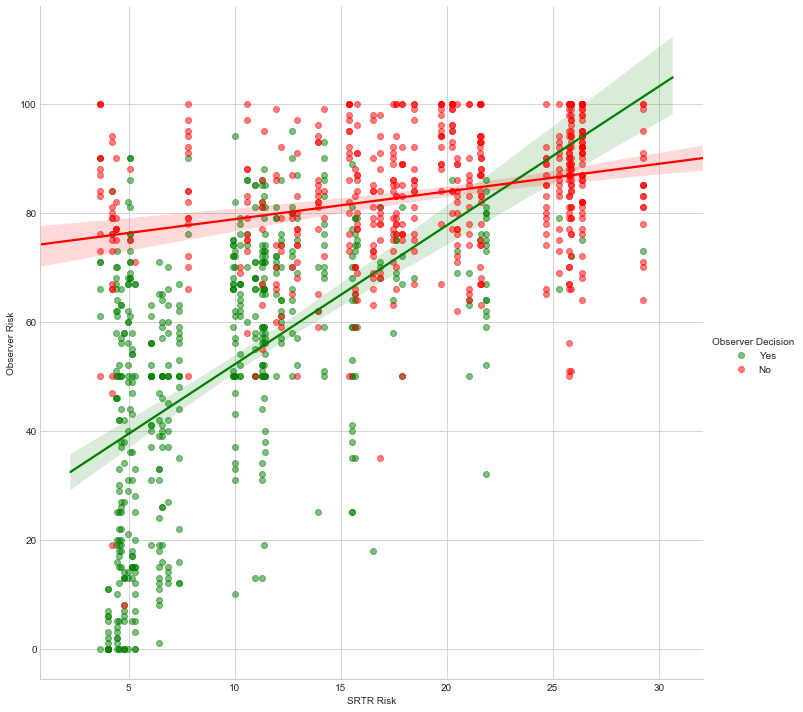

In [26]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


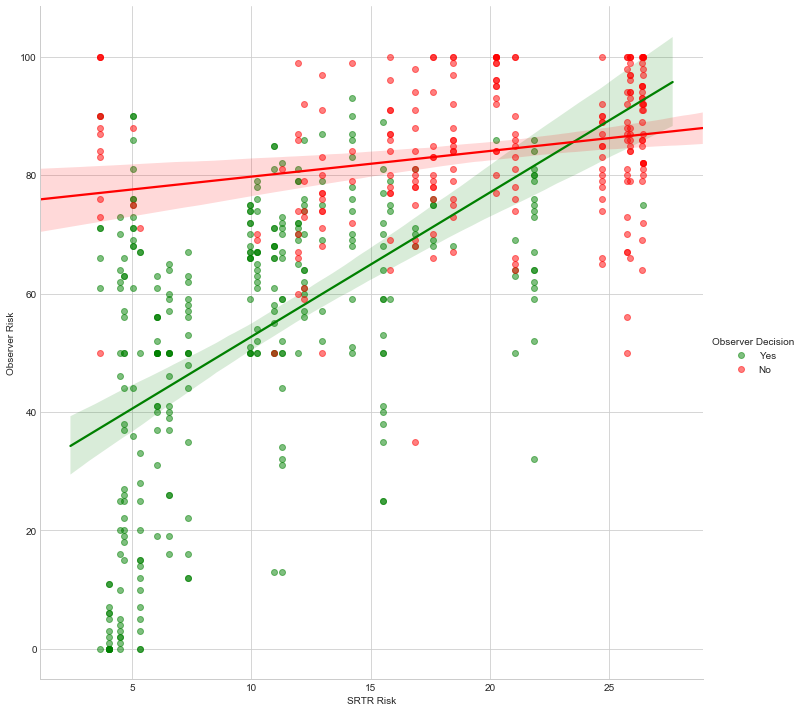

In [27]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[master_data['Scenario ID'] <= 30], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all_1-30.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


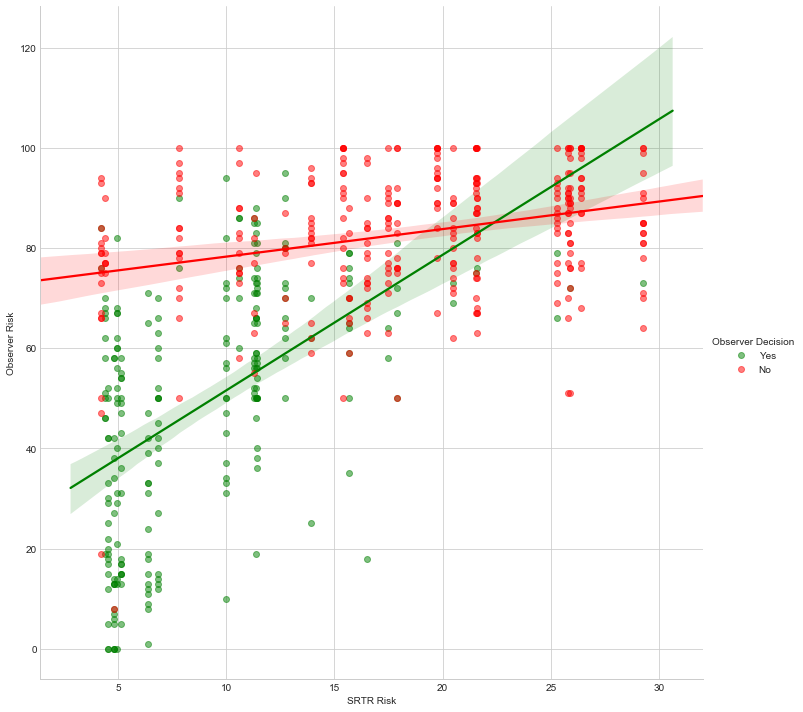

In [28]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[master_data['Scenario ID'] > 30], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all_31-60.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


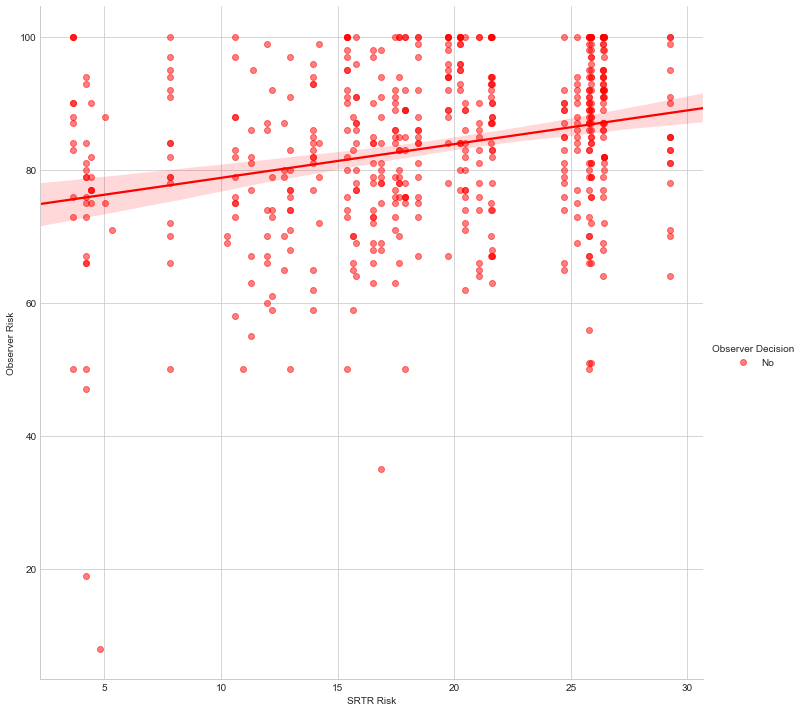

In [29]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


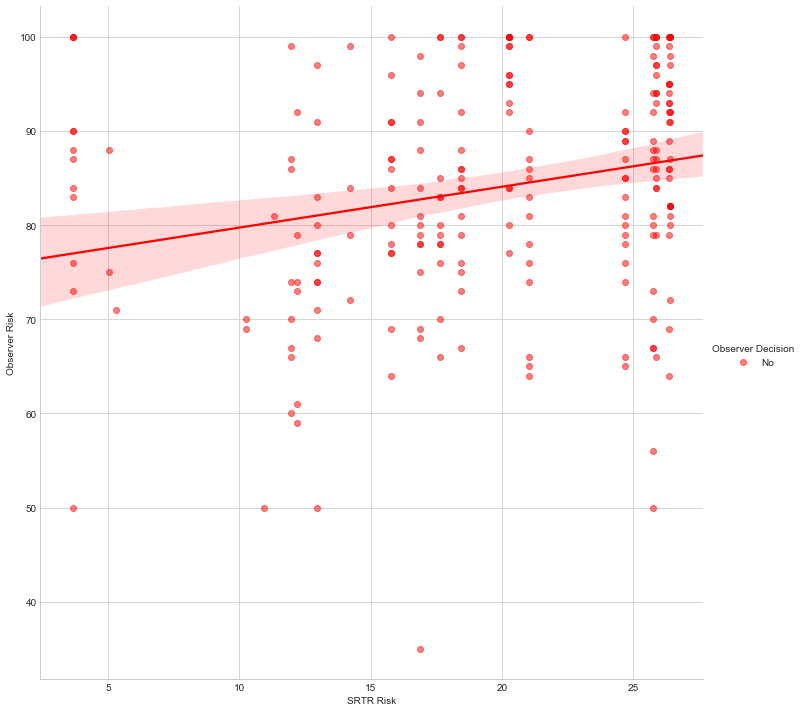

In [30]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no & (master_data['Scenario ID'] <= 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no_1-30.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


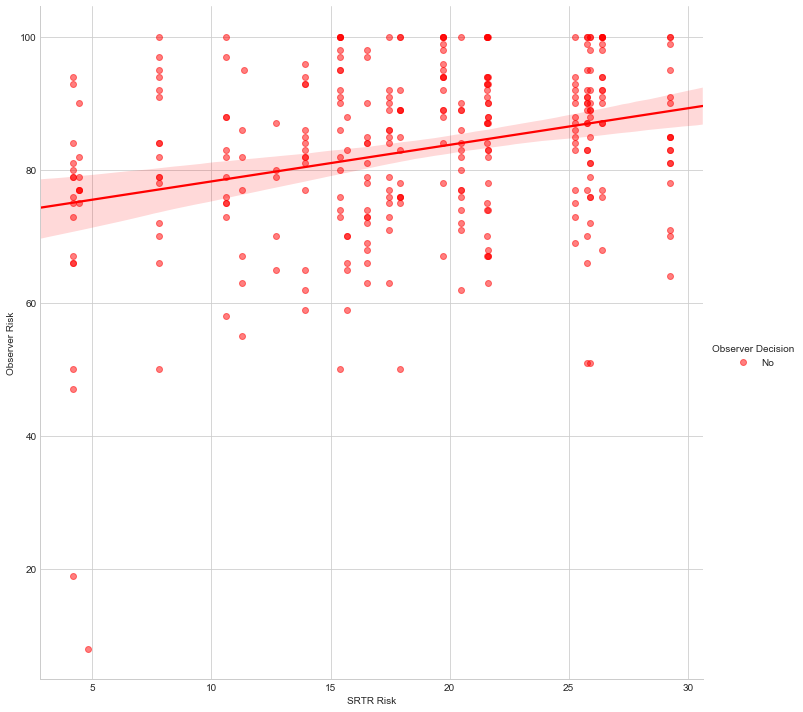

In [31]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no & (master_data['Scenario ID'] > 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no_31-60.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


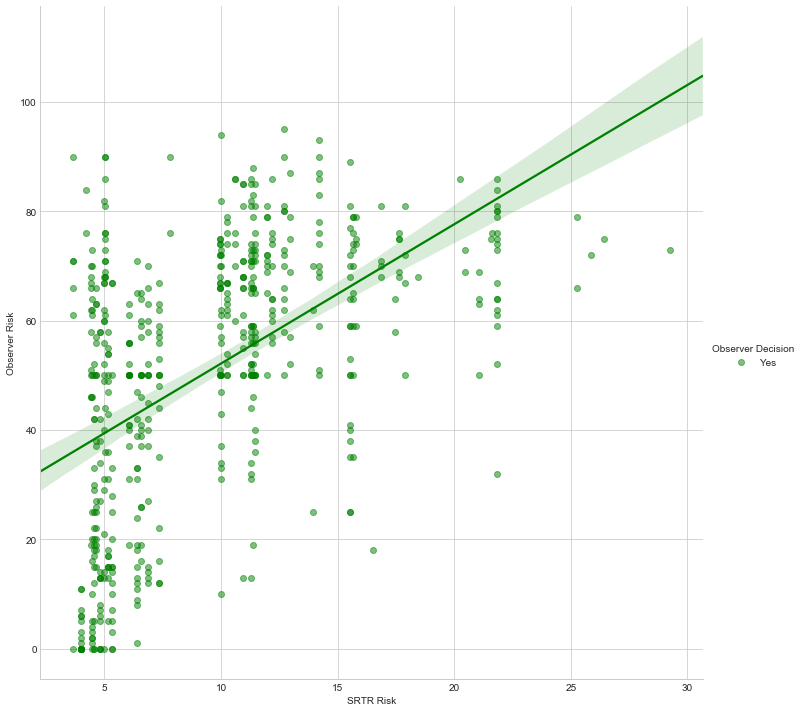

In [32]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


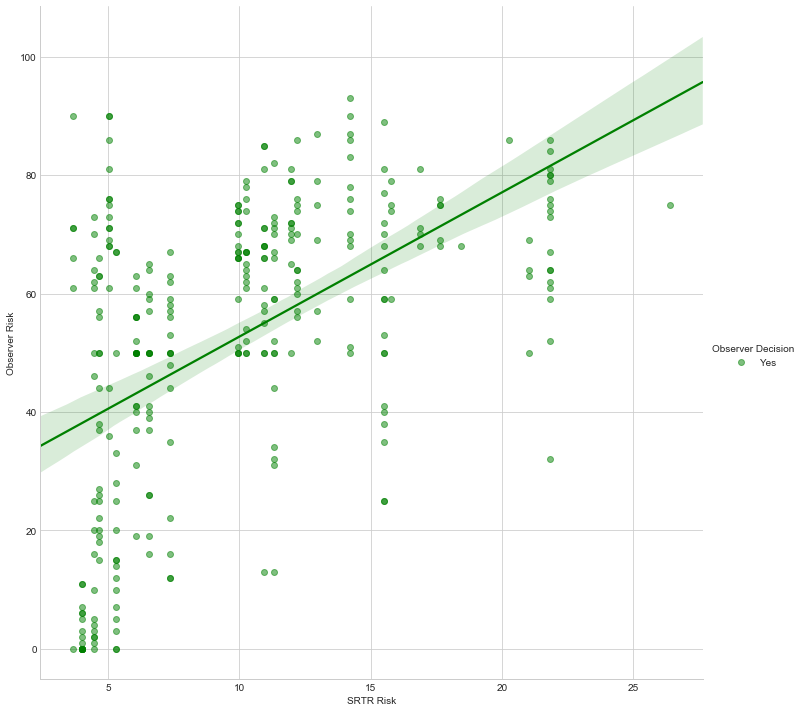

In [33]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes & (master_data['Scenario ID'] <= 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes_1-30.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


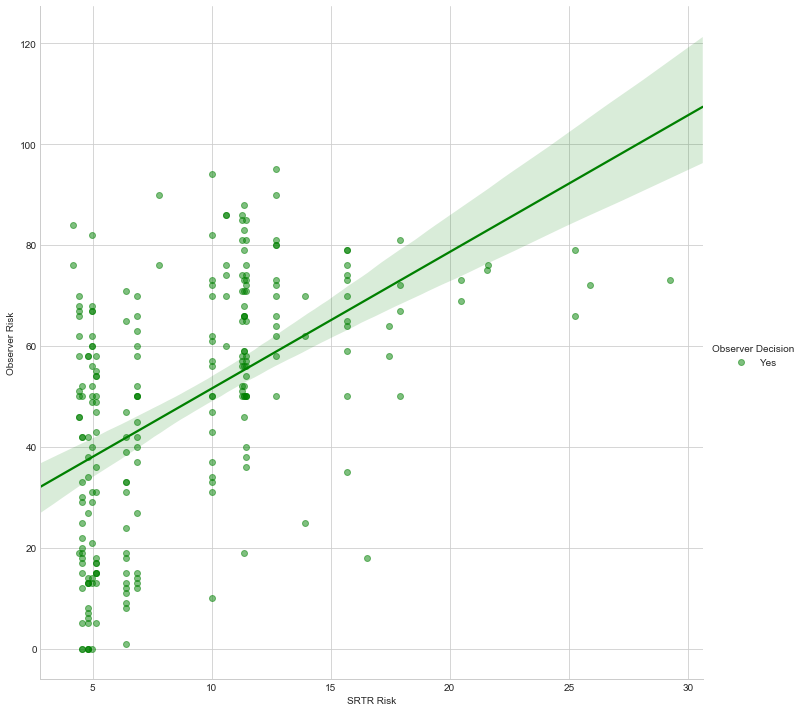

In [34]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes & (master_data['Scenario ID'] > 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes_31-60.jpg')

C:\Users\Myrtle\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Myrtle\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


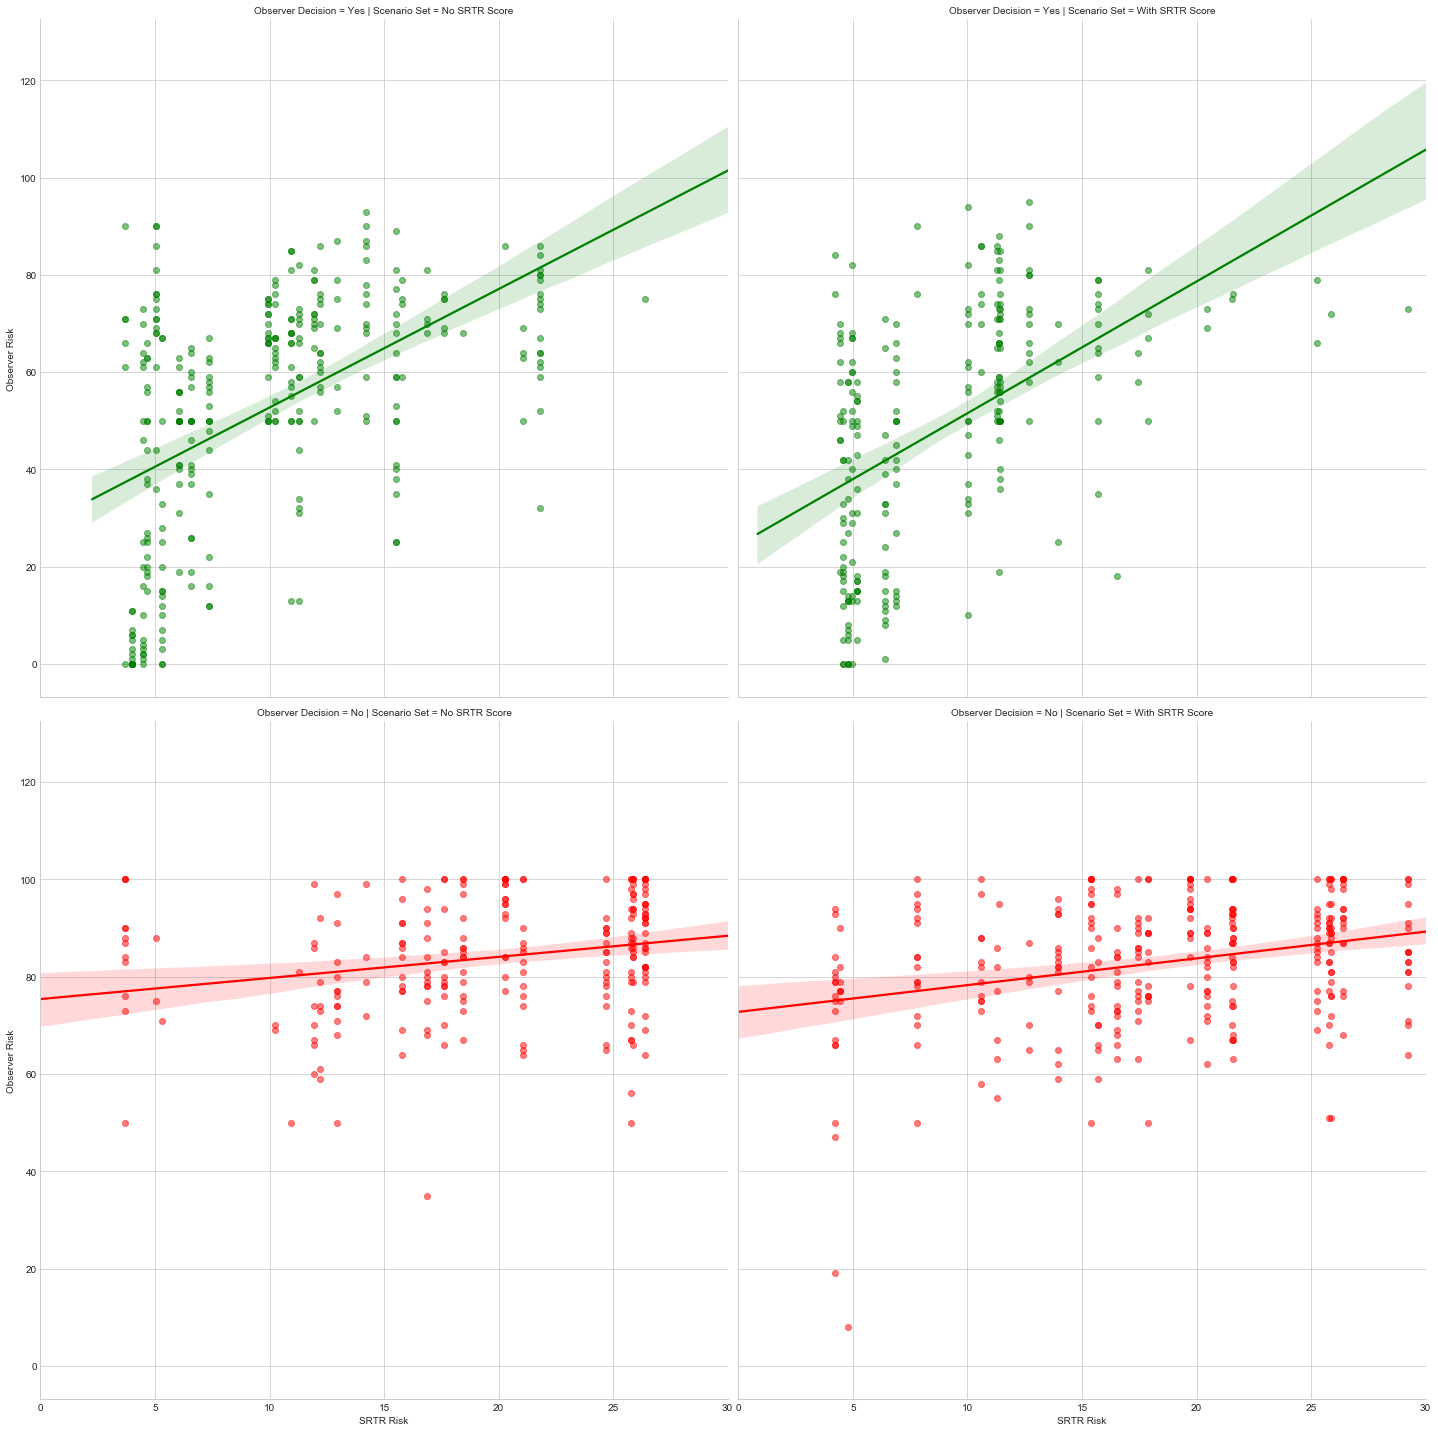

In [22]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", row='Observer Decision', col='Scenario Set', data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)
fit_yes.set(xlim=(0, 30))

plt.savefig('plot_SRTRvsObserver_fit_sliced.jpg')